In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
#import data
df = pd.read_csv('../Datasets/AMD Historical Data.csv')

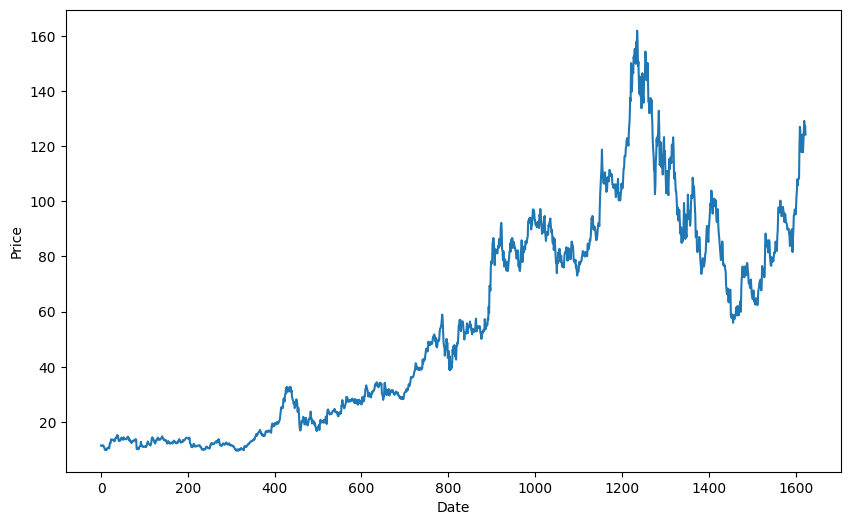

In [27]:
figure=df['Price'].values
plt.figure(figsize=(10,6))
plt.plot(figure)
plt.xlabel('Date')
plt.ylabel('Price') 
plt.show()

In [28]:
#Xây dựng mô hỉnh với Bayesian Dynamic Linear Model
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason


In [29]:
df = df.reset_index(drop=True)
 # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [30]:
from pydlm import dlm, trend, seasonality

# Tạo model DLM
my_dlm = dlm(train_data['Price'])

# Thêm trend component
my_dlm = my_dlm + trend(degree=1, name='trend', w=1.0)

# Thêm seasonality component với chu kỳ 52 tuần
my_dlm = my_dlm + seasonality(period=52, name='season', w=1.0)

In [31]:

# Fit the DLM to the training data
my_dlm.fit()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [32]:
# Predict on validation set
my_dlm.predictN(N=30)


([85.75825667683621,
  85.74675026070075,
  82.65756612563484,
  82.34191522600504,
  80.4318021162589,
  82.10891850457968,
  80.80591330890078,
  79.98233813401343,
  81.3446408640629,
  81.78618596193655,
  81.03817524123397,
  80.745151545249,
  80.35244646894749,
  81.6564001757672,
  82.7122423595152,
  81.39582418246998,
  81.16067192034414,
  82.16252048454969,
  82.77497268197143,
  83.34694526195831,
  84.02654202342796,
  85.64150771879477,
  83.96800943175157,
  86.47206078147586,
  85.27710953111593,
  88.95338810936738,
  88.16762997058672,
  86.52948920175061,
  89.47254281850849,
  90.31890215099921],
 [34.774803397827725,
  34.637278959154244,
  34.501031113095245,
  34.366047111707374,
  34.232314307482035,
  34.09982015376693,
  33.968552205146125,
  33.83849811777999,
  33.709645649707014,
  33.58198266110824,
  33.45549711453612,
  33.33017707510844,
  33.206010710668544,
  33.08298629191326,
  32.960748410945854,
  32.83996562239103,
  32.720294472162124,
  32.601

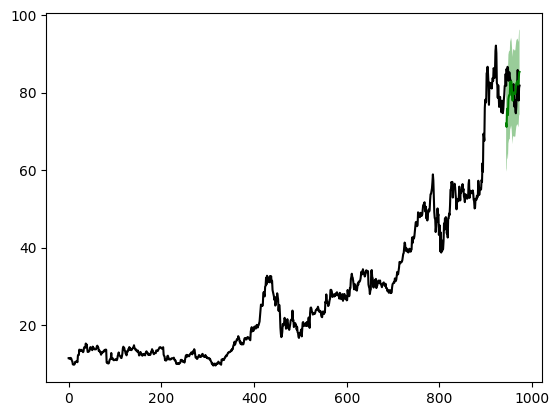

In [33]:
#Dự đoán trên tập train
my_dlm.plotPredictN(N=30, date=my_dlm.n-30)


In [34]:
# Predict on validation data
val_preds, val_vars = my_dlm.predictN(N=val_size)

# Predict on test data
test_preds, test_vars = my_dlm.predictN(N=test_size)
# Predict on train data
train_preds, train_vars = my_dlm.predictN(N=train_size)

In [35]:
# Các giá trị thực tế cho validation, test và train data
val_actual = val_data['Price'].values
test_actual = test_data['Price'].values
train_actual = train_data['Price'].values

In [36]:
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

# Regression metrics
test_rmse = np.sqrt(np.mean((test_preds - test_actual)**2))
test_mse = mean_squared_error(test_actual, test_preds)
test_mae = mean_absolute_error(test_actual, test_preds)

valid_rmse = np.sqrt(np.mean((val_preds - val_actual)**2))
valid_mse = mean_squared_error(val_actual, val_preds)
valid_mae = mean_absolute_error(val_actual, val_preds)

print('Testing RMSE:', test_rmse)
print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)

print('Validation RMSE:', valid_rmse)
print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)

Testing RMSE: 37.76883481330771
Testing MSE: 1426.4848831549245
Testing MAE: 28.013770168171334
Validation RMSE: 15.954925683814732
Validation MSE: 254.559653576051
Validation MAE: 14.185669219762971


In [38]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

In [39]:
# Dự đoán 30 ngày tiếp theo sau tập validation
future_preds, future_vars = my_dlm.predictN(N=30)

# In ra dự đoán cho 30 ngày tiếp theo
print("Predictions for the next 30 days:")
print(future_preds)

Predictions for the next 30 days:
[85.75825667683621, 85.74675026070075, 82.65756612563484, 82.34191522600504, 80.4318021162589, 82.10891850457968, 80.80591330890078, 79.98233813401343, 81.3446408640629, 81.78618596193655, 81.03817524123397, 80.745151545249, 80.35244646894749, 81.6564001757672, 82.7122423595152, 81.39582418246998, 81.16067192034414, 82.16252048454969, 82.77497268197143, 83.34694526195831, 84.02654202342796, 85.64150771879477, 83.96800943175157, 86.47206078147586, 85.27710953111593, 88.95338810936738, 88.16762997058672, 86.52948920175061, 89.47254281850849, 90.31890215099921]


In [40]:
#Tạo một mảng chứa toàn bộ dữ liệu của tập train, validation và test
allPreds = np.concatenate([train_preds,test_preds, val_preds])


In [41]:
#Tạo mảng index tương ứng với tập allPreds
days = np.arange(0, len(allPreds))


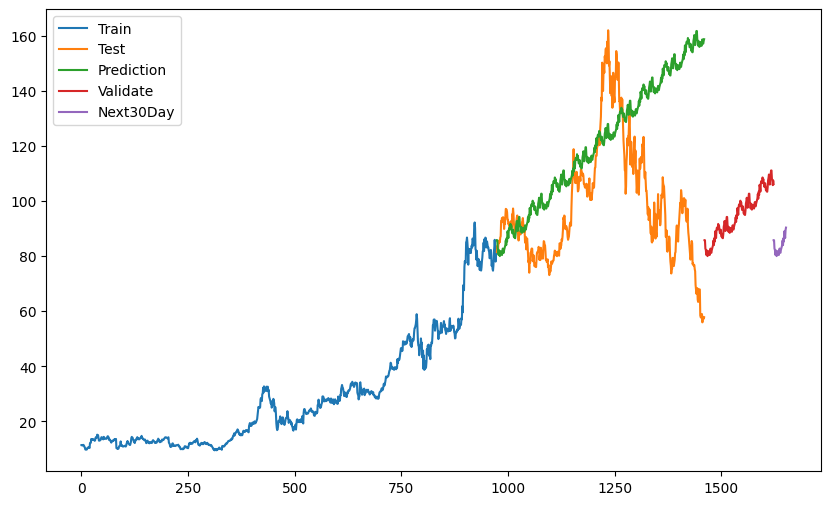

In [42]:
#Vẽ hình
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
#plt.plot(val_data.index, val_data['Price'])
plt.plot(days[len(train_data.index):len(train_data.index)+len(test_preds)], test_preds, label='Prediction')
plt.plot(days[len(train_data.index)+len(test_preds):], val_preds, label='Validate')
plt.plot(last_data,future_preds, label='Next30Day')

#plt.plot(pred_df.index, pred_df['Price'], label='Predicted')
plt.legend(['Train', 'Test', 'Prediction', 'Validate', 'Next30Day'])
plt.show()

In [44]:
def mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Regression metrics
test_rmse = np.sqrt(np.mean((test_preds - test_actual)**2))
test_mse = mean_squared_error(test_actual, test_preds)
test_mae = mean_absolute_error(test_actual, test_preds)
test_mape = mape(test_actual, test_preds)

valid_rmse = np.sqrt(np.mean((val_preds - val_actual)**2))
valid_mse = mean_squared_error(val_actual, val_preds)
valid_mae = mean_absolute_error(val_actual, val_preds)
valid_mape = mape(val_actual, val_preds)

print('Testing RMSE:', test_rmse)
# print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
print("Testing MAPE:", test_mape)

print('Validation RMSE:', valid_rmse)
# print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)
print("Validation MAPE:", valid_mape)

Testing RMSE: 37.76883481330771
Testing MAE: 28.013770168171334
Testing MAPE: 32.58848314187392
Validation RMSE: 15.954925683814732
Validation MAE: 14.185669219762971
Validation MAPE: 18.74024358819034
